### model

In [2]:
import os
import requests
from requests.adapters import HTTPAdapter
from torch import nn
from torch.nn import functional as F
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from metrics import AverageMeter
from loss import batch_all_triplet_loss, batch_hard_triplet_loss
from tqdm import tqdm
from test import result
import matplotlib.pyplot as plt

In [3]:
class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) 
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, 
            momentum=0.1, 
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [4]:
class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out

In [5]:
class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out

In [6]:
class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out

In [7]:
class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out

In [8]:
class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [9]:
class InceptionResnetV1(nn.Module):
    def __init__(self, pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None):
        super().__init__()

        # Set simple attributes
        self.pretrained = pretrained
        self.classify = classify
        self.num_classes = num_classes

        if pretrained == 'vggface2':
            tmp_classes = 8631
        elif pretrained == 'casia-webface':
            tmp_classes = 10575
        elif pretrained is None and self.classify and self.num_classes is None:
            raise Exception('Exception occured.')
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 512, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)

        if pretrained is not None:
            self.logits = nn.Linear(512, tmp_classes)
            load_weights(self, pretrained)

        if self.classify and self.num_classes is not None:
            self.logits = nn.Linear(512, self.num_classes)

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
        x = self.last_bn(x)
        if self.classify:
            x = self.logits(x)
        else:
            x = F.normalize(x, p=2, dim=1)
        return x

In [10]:
def load_weights(mdl, name):
    if name == 'vggface2':
        path = 'https://github.com/timesler/facenet-pytorch/releases/download/v2.2.9/20180402-114759-vggface2.pt'
    elif name == 'casia-webface':
        path = 'https://github.com/timesler/facenet-pytorch/releases/download/v2.2.9/20180408-102900-casia-webface.pt'
    else:
        raise ValueError('Pretrained models only exist for "vggface2" and "casia-webface"')

    model_dir = os.path.join(get_torch_home(), 'checkpoints')
    os.makedirs(model_dir, exist_ok=True)

    cached_file = os.path.join(model_dir, os.path.basename(path))
    if not os.path.exists(cached_file):
        download_url_to_file(path, cached_file)

    state_dict = torch.load(cached_file)
    mdl.load_state_dict(state_dict)

In [11]:
def get_torch_home():
    torch_home = os.path.expanduser(
        os.getenv(
            'TORCH_HOME',
            os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')
        )
    )
    return torch_home

### testing

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../Result/test_new_result.png')

In [13]:
def result(model,dataloader, device):
    dist = []
    with torch.no_grad():
        model.eval()
        for _, eval_data in enumerate(tqdm(dataloader)):
            eval_image = eval_data['image'].to(device)
            print(eval_image)
            eval_out = model(eval_image)['embeddings']
            eval_pair = eval_data['pair_image'].to(device)
            eval_pait_out = model(eval_pair)['embeddings']
            # print(eval_out)
            # print("-"*10)
            # print(eval_pait_out)
            distance = torch.norm(eval_out - eval_pait_out, dim=1)
            dist.append(list(distance.cpu().numpy()))

    new_dist = []
    for i in range(len(dist)):
        for j in range(len(dist[i])):
            new_dist.append(dist[i][j])
    dist = np.asarray(new_dist)

    return dist

In [14]:
def evalulate(model, eval_loader1, eval_loader2, device):
    dist1 = result(model,eval_loader1, device)
    dist2 = result(model,eval_loader2, device)

    with open('test.npy', 'wb') as f:
        np.save(f, dist1)
        np.save(f, dist2)

    same_hist = plt.hist(dist1, 100, range=[np.floor(np.min([dist1.min(), dist2.min()])),np.ceil(np.max([dist1.max(), dist2.max()]))], alpha=0.5, label='same')
    diff_hist = plt.hist(dist2, 100, range=[np.floor(np.min([dist1.min(), dist2.min()])),np.ceil(np.max([dist1.max(), dist2.max()]))], alpha=0.5, label='diff')
    difference = same_hist[0] - diff_hist[0]
    difference[:same_hist[0].argmax()] = np.Inf
    difference[diff_hist[0].argmax():] = np.Inf
    return (same_hist[1][np.where(difference <= 0)[0].min()] + same_hist[1][np.where(difference <= 0)[0].min() - 1])/2


In [15]:
def test(model, test_loader, dist_threshold, device):
    label = []
    pred = []
    print(model)
    with torch.no_grad():
        model.eval()
        for _, test_data in enumerate(tqdm(test_loader)):
            test_image = test_data['image'].to(device)
            test_target = test_data['target']
            test_out = model(test_image)
            test_pair = test_data['pair_image'].to(device)
            test_pair_target = test_data['pair_target']
            test_pait_out = model(test_pair)
            distance = torch.norm(test_out['embeddings'] - test_pait_out['embeddings'], dim=1)
            label.append(list((test_target == test_pair_target).cpu().numpy()))
            pred.append(list((distance <= dist_threshold).cpu().numpy()))

    new_label = []
    new_pred = []
    for i in range(len(label)):
        for j in range(len(label[i])):
            new_label.append(label[i][j])
            new_pred.append(pred[i][j])


    new_pred = [0 if i == False else 1 for i in new_pred]
    new_label = [0 if i == False else 1 for i in new_label]
    new_pred = np.array(new_pred)
    new_label = np.array(new_label)
    num_true = np.sum(new_pred==new_label)
    acc = num_true/len(new_label)
    print('Accuracy is:', acc)
    print(classification_report(new_label, new_pred))
    cm = confusion_matrix(new_label, new_pred)
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cm, [0, 1])

### training

In [16]:
def save(save_path, model, optimizer=None, scheduler=None):
    if save_path==None:
        return
    checkpoint = {
        'model': model,
        'optimizer': optimizer,
        'scheduler': scheduler,
    }
    save_path = '../Model/' + save_path
    torch.save(checkpoint, save_path)
    print(f'Model saved to ==> {save_path}')

In [17]:
def load(name, model, optimizer):
    checkpoint = torch.load('../Model/' + name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

In [18]:
def train(model,train_loader,valid_loader,valid_loader1,valid_loader2,optimizer,scheduler,num_epochs,eval_every,margin,device,name):
    epoch_loss_list = {'train':[], 'valid':[]}
    IOU_list = []
    global_step = 0
    train_loss = AverageMeter()
    valid_loss = AverageMeter()
    best_IOU = 1
    total_step = len(train_loader)*num_epochs
    count = 0
    print(f'total steps: {total_step}')
    for epoch in range(num_epochs):
        print(f'epoch {epoch+1}')
        #losses = []
        for _, data in enumerate(tqdm(train_loader)):
            if count > 0:
                break
            count += 1
            model.train()
            inputs = data['image'].to(device) # inputs
            target = data['target'].to(device) # targets
            embeddings = model(inputs)
            loss, _ = batch_all_triplet_loss(target, embeddings, margin=margin, epoch=epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.update(loss.item())
            global_step += 1
            current_lr = optimizer.param_groups[0]['lr']

            ### print
            if global_step % eval_every == 0:
                model.eval()
                for _, data in enumerate(tqdm(valid_loader)):
                    inputs = data['image'].to(device) # inputs
                    target = data['target'].to(device) # targets
                    embeddings = model(inputs)
                    loss, _ = batch_all_triplet_loss(target, embeddings, margin=margin, epoch=epoch)
                    valid_loss.update(loss.item())

                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, lr: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, train_loss.avg, valid_loss.avg ,current_lr))

        # valid
        dist1 = result(model,valid_loader1,device)
        dist2 = result(model,valid_loader2,device)
        same_hist = plt.hist(dist1, 100, range=[np.floor(np.min([dist1.min(), dist2.min()])),np.ceil(np.max([dist1.max(), dist2.max()]))], alpha=0.5, label='same')
        diff_hist = plt.hist(dist2, 100, range=[np.floor(np.min([dist1.min(), dist2.min()])),np.ceil(np.max([dist1.max(), dist2.max()]))], alpha=0.5, label='diff')
        plt.legend(loc='upper right')
        plt.savefig('../Result/distribution_epoch'+str(epoch+1)+'.png')
        difference = same_hist[0] - diff_hist[0]
        difference[:same_hist[0].argmax()] = np.Inf
        difference[diff_hist[0].argmax():] = np.Inf
        dist_threshold = (same_hist[1][np.where(difference <= 0)[0].min()] + same_hist[1][np.where(difference <= 0)[0].min() - 1])/2
        overlap = np.sum(dist1>=dist_threshold) + np.sum(dist2<=dist_threshold)
        IOU = overlap / (dist1.shape[0] * 2 - overlap)
        print('dist_threshold:',dist_threshold,'overlap:',overlap,'IOU:',IOU)
        plt.clf()

        epoch_loss_list['train'].append(train_loss.avg)
        epoch_loss_list['valid'].append(valid_loss.avg)
        IOU_list.append(IOU)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
        ax1.plot(range(len(epoch_loss_list['train'])), epoch_loss_list['train'], label=('train_loss'))
        ax1.plot(range(len(epoch_loss_list['valid'])), epoch_loss_list['valid'], label=('valid_loss'))
        ax2.plot(range(len(IOU_list)), IOU_list, label=('IOU'))
        ax1.legend(prop={'size': 15})
        ax2.legend(prop={'size': 15})
        plt.savefig('../Result/loss.png')
        plt.clf()

        if IOU < best_IOU:
            best_IOU = IOU
            save(name, model, optimizer, scheduler)

        train_loss.reset()
        valid_loss.reset()
        scheduler.step()
    print('Finished Training')

### Utilities

In [19]:
import torch
import torch.nn as nn
from torch import optim
from sampler import PKSampler, PKSampler2

def get_Sampler(sampler,dataset,p=15,k=20):
    if sampler == 'all':
        return PKSampler2(dataset, p=p, k=k)
    else:
        return PKSampler(dataset, p=p, k=k)

def get_Optimizer(model, optimizer_type=None, lr=1e-3, weight_decay=1e-3):
    if(optimizer_type=='sgd'):
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif(optimizer_type=='rmsprop'):
        return optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif(optimizer_type=='adadelta'):
        return optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


def get_Scheduler(optimizer, lr, scheduler_name=None):
    if(scheduler_name=='cyclic'):
        return optim.lr_scheduler.CyclicLR(optimizer, base_lr=5e-4, max_lr=lr, step_size_up=500)
    elif(scheduler_name=='cosine'):
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
    elif(scheduler_name=='multistep'):
        # return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,13,30], gamma=0.3)
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,20,40], gamma=0.1)
    else:
        return optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

## Sampler.py

In [20]:
from torch.utils.data.sampler import Sampler
import itertools
import numpy as np

def samples(df):
    label_to_samples = []
    samples = []
    label = 0
    for index, row in df.iterrows():
        if index == 0:
            samples.append(index)
            label = row['target']
        else:
            if row['target'] != label:
                label_to_samples.append(samples)
                samples = []
                label = row['target']
            samples.append(index)
    return label_to_samples

In [21]:
class PKSampler(Sampler):

    def __init__(self, data_source, p=15, k=20):
        super().__init__(data_source)
        self.p = p
        self.k = k
        self.data_source = data_source

    def __iter__(self):
        pk_count = len(self) // (self.p * self.k)
        for _ in range(pk_count):
            labels = np.random.choice(np.arange(len(self.data_source.label_to_samples)), self.p, replace=False)
            for l in labels:
                indices = self.data_source.label_to_samples[l]
                replace = True if len(indices) < self.k else False
                for i in np.random.choice(indices, self.k, replace=replace):
                    yield i

    def __len__(self):
        pk = self.p * self.k
        samples = ((len(self.data_source) - 1) // pk + 1) * pk
        return samples

In [22]:
def grouper(iterable, n):
    it = itertools.cycle(iter(iterable))
    for _ in range((len(iterable) - 1) // n + 1):
        yield list(itertools.islice(it, n))

In [23]:
class PKSampler2(Sampler):

    def __init__(self, data_source, p=15, k=20):
        super().__init__(data_source)
        self.p = p
        self.k = k
        self.data_source = data_source

    def __iter__(self):
        rand_labels = np.random.permutation(np.arange(len(self.data_source.label_to_samples)))
        for labels in grouper(rand_labels, self.p):
            for l in labels:
                indices = self.data_source.label_to_samples[l]
                replace = True if len(indices) < self.k else False
                for j in np.random.choice(indices, self.k, replace=replace):
                    yield j

    def __len__(self):
        num_labels = len(self.data_source.label_to_samples)
        samples = ((num_labels - 1) // self.p + 1) * self.p * self.k
        return samples

### Models

In [24]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from facenet_pytorch import MTCNN, InceptionResnetV1
from efficientnet_pytorch import EfficientNet
import timm

In [25]:
class InceptionResnet(nn.Module):
    def __init__(self, device, pool=None, dropout=0.3, pretrain=True):
        super(InceptionResnet, self).__init__()
        if pretrain:
            self.net = InceptionResnetV1(pretrained='vggface2', dropout_prob=dropout, device=device)
        else:
            self.net = InceptionResnetV1(dropout_prob=dropout, device=device)
        self.out_features = self.net.last_linear.in_features
        if pool == 'gem':
            self.net.avgpool_1a = GeM(p_trainable=True)
    def forward(self, x):
        return self.net(x)

class EfficientNetEncoderHead(nn.Module):
    def __init__(self, depth, pretrain=True):
        super(EfficientNetEncoderHead, self).__init__()
        self.depth = depth
        if pretrain:
            self.net = EfficientNet.from_pretrained(f'efficientnet-b{self.depth}')
        else:
            self.net = EfficientNet.from_name(f'efficientnet-b{self.depth}')
        self.out_features = self.net._fc.in_features
    def forward(self, x):
        return self.net.extract_features(x)

class SEResNeXt101(nn.Module):
    def __init__(self, pretrain=True):
        super(SEResNeXt101, self).__init__()
        self.net = timm.create_model('gluon_seresnext101_32x4d', pretrained=pretrain)
        # the output size of this model
        self.out_features = self.net.fc.in_features
    def forward(self, x):
        return self.net.forward_features(x)


def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=True):
        super(GeM,self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class FaceNet(nn.Module):
    def __init__(self, model_name=None, pool=None, dropout=0.0, pretrain=True, embedding_size=512, device=None):
        super(FaceNet, self).__init__()
        self.model_name = model_name
        if(model_name=='resnet'):
            self.model = SEResNeXt101(pretrain)
        elif(model_name=='effnet'):
            self.model = EfficientNetEncoderHead(depth=5, pretrain=pretrain)
        else:
            self.model = InceptionResnet(device, pool=pool, dropout=dropout, pretrain=pretrain)    
        if(pool == "gem"):    
            self.global_pool = GeM(p_trainable=True)
        else:
            self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.neck = nn.Sequential(
                nn.Linear(self.model.out_features, embedding_size, bias=True),
                nn.BatchNorm1d(embedding_size, eps=0.001),
            )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
      
        if self.model_name == None:
            return self.model(x)
        x = self.model(x)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x[:,:,0,0]
        embeddings = self.neck(x)
        return embeddings

In [26]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine

class FaceNet2(nn.Module):
    def __init__(self, num_classes, model_name=None, pool=None, dropout=0.0, embedding_size=512, device='cuda', pretrain=True):
        super(FaceNet2, self).__init__()
        self.model_name = model_name

  
        if(model_name=='resnet'):
            self.model = SEResNeXt101(pretrain)
        elif(model_name=='effnet'):
            self.model = EfficientNetEncoderHead(depth=3, pretrain=pretrain)
        else:
            self.model = InceptionResnet(device, pool=pool, dropout=dropout, pretrain=pretrain)
        if(pool == "gem"):
            self.global_pool = GeM(p_trainable=True)
        else:
            self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.neck = nn.Sequential(
                nn.Linear(self.model.out_features, embedding_size, bias=True),
                nn.BatchNorm1d(embedding_size, eps=0.001),
            )
        self.dropout = nn.Dropout(p=dropout)
        self.head = ArcMarginProduct(embedding_size, num_classes)

    def forward(self, x):
        if self.model_name == None:
            embeddings = self.model(x)
            logits = self.head(embeddings)
            return {'logits': logits, 'embeddings': embeddings}
        x = self.model(x)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x[:,:,0,0]
        embeddings = self.neck(x)
        logits = self.head(embeddings)
        return {'logits': logits, 'embeddings': embeddings}

## Metrics.py

In [27]:
class AverageMeter:
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Loss.py

In [28]:
import torch
def _pairwise_distances(embeddings, squared=False):
    dot_product = torch.matmul(embeddings, embeddings.t())
    square_norm = torch.diag(dot_product)
    distances = square_norm.unsqueeze(0) - 2.0 * dot_product + square_norm.unsqueeze(1)
    distances[distances < 0] = 0

    if not squared:
        mask = distances.eq(0).float()
        distances = distances + mask * 1e-16

        distances = (1.0 -mask) * torch.sqrt(distances)

    return distances

def _get_triplet_mask(labels):
    indices_equal = torch.eye(labels.size(0)).bool()
    indices_not_equal = ~indices_equal
    i_not_equal_j = indices_not_equal.unsqueeze(2)
    i_not_equal_k = indices_not_equal.unsqueeze(1)
    j_not_equal_k = indices_not_equal.unsqueeze(0)

    distinct_indices = (i_not_equal_j & i_not_equal_k) & j_not_equal_k


    label_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    i_equal_j = label_equal.unsqueeze(2)
    i_equal_k = label_equal.unsqueeze(1)

    valid_labels = ~i_equal_k & i_equal_j

    return valid_labels & distinct_indices.cuda()


def _get_anchor_positive_triplet_mask(labels, device):
    indices_equal = torch.eye(labels.size(0)).bool().to(device)
    indices_not_equal = ~indices_equal
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)

    return labels_equal.to(device) & indices_not_equal.to(device)


def _get_anchor_negative_triplet_mask(labels):

    return ~(labels.unsqueeze(0) == labels.unsqueeze(1))


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False, device='cpu'):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels, device).float()
    anchor_positive_dist = mask_anchor_positive.to(device) * pairwise_dist.to(device)
    hardest_positive_dist, _ = anchor_positive_dist.max(1, keepdim=True)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
    max_anchor_negative_dist, _ = pairwise_dist.max(1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)
    hardest_negative_dist, _ = anchor_negative_dist.min(1, keepdim=True)
    tl = hardest_positive_dist.to(device) - hardest_negative_dist.to(device) + margin
    tl[tl < 0] = 0
    triplet_loss = tl.mean()

    return triplet_loss

def batch_all_triplet_loss(labels, embeddings, margin, squared=False, epoch=0):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = pairwise_dist.unsqueeze(2)
    anchor_negative_dist = pairwise_dist.unsqueeze(1)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin
    mask = _get_triplet_mask(labels)
    triplet_loss = mask.float() * triplet_loss
    triplet_loss[triplet_loss < margin] = 0
    valid_triplets = triplet_loss[triplet_loss > 1e-16]
    num_positive_triplets = valid_triplets.size(0)
    num_valid_triplets = mask.sum()

    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets.float() + 1e-16)
    triplet_loss = triplet_loss.sum() / (num_positive_triplets + 1e-16)
    return triplet_loss, fraction_positive_triplets

## Dataset.py

In [29]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class TripletDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, mode: str, label_to_samples=None):
        self.df = dataframe
        self.mode = mode
        transforms_list1 = [transforms.Resize((128,128)),
                          transforms.RandomHorizontalFlip(p=0.5),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])]
        transforms_list2 = [transforms.Resize((128,128)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])]
        self.transforms_train = transforms.Compose(transforms_list1)
        self.transforms_test = transforms.Compose(transforms_list2)
        self.label_to_samples = label_to_samples
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        target = self.df.iloc[index]['target']
        image_path = self.df.iloc[index]['path']
        img = Image.open(image_path)

        if self.mode=='train' or self.mode=='valid':
            img = self.transforms_train(img)
            return {'image':img, 'target':target}
        else:
            img = self.transforms_test(img)
            pair_path = self.df.iloc[index]['pair_path']
            pair_target = self.df.iloc[index]['pair_target']
            pair_img = Image.open(pair_path)
            pair_img = self.transforms_test(pair_img)
            return {'image':img, 'target':target, 'pair_image':pair_img, 'pair_target':pair_target}

## main_test.py

Device: cpu


100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [47:08<00:00,  6.20s/it]


1.0499999523162842


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [05:16<00:00,  6.21s/it]


Accuracy: 0.9577290959580377
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3241
           1       0.99      0.93      0.96      3241

    accuracy                           0.96      6482
   macro avg       0.96      0.96      0.96      6482
weighted avg       0.96      0.96      0.96      6482

Confusion matrix, without normalization
[[3197   44]
 [ 230 3011]]


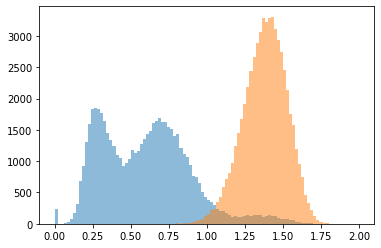

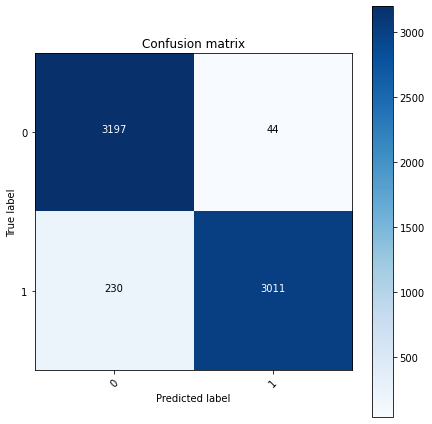

In [30]:
from dataset import TripletDataset
from model import FaceNet
from sampler import samples
from train import train, load, save
from test import evalulate, test
from util import get_Optimizer, get_Scheduler, get_Sampler

import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary

import os

if __name__ == "__main__":
 
    BATCH_SIZE=128
    NUM_WORKERS = 2
    embedding_size = 512
  
    sampler = None
    weight_decay = 1e-3
    lr = 3e-6
    dropout = 0.3
    
    model_name = None
    pretrain = True
    
    pool= None
    
    scheduler_name = 'multistep'
    
    optimizer_type = None
    num_epochs = 20
    eval_every = 1000
   
    margin=2
   
    name = 'arcface1.pt'
    load_local_model = False


    os.environ['CUDA_VISIBLE_DEVICES']='2'
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Device:",device)

    df_eval1 = pd.read_csv('../Datasets/eval_same.csv')
    df_eval2 = pd.read_csv('../Datasets/eval_diff.csv')
    df_test = pd.read_csv('../Datasets/test.csv')

    eval_dataset1 = TripletDataset(df_eval1, mode='eval')
    eval_dataset2 = TripletDataset(df_eval2, mode='eval')
    test_dataset = TripletDataset(df_test, mode='test')

    eval_loader1 = DataLoader(eval_dataset1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False)
    eval_loader2 = DataLoader(eval_dataset2, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False)
    facenet = torch.load('../models/InceptionResNetV1_ArcFace.pt')
    device = torch.device('cpu')


    dist_threshold = evalulate(facenet, eval_loader1, eval_loader2, device)
    print(dist_threshold)
    test(facenet,test_loader,dist_threshold,device)
